In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import matplotlib.pyplot as plt
import seaborn as sns
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/taxa-de-abandono-escolar-por-renda-mdia-brasil/AbandonoEscolar_RendaMedia_2013_2023.parquet
/kaggle/input/taxa-de-abandono-escolar-por-renda-mdia-brasil/AbandonoEscolar_RendaMedia_2013_2023.csv


*O objetivo desta análise é responder às seguintes perguntas:*
* *Existe uma correlação entre a renda média mensal e a evasão escolar nas unidades federativas do Brasil?*
* *Como essa relação evoluiu entre os anos de 2012 a 2015?*
* *Como essa correlação se distribui entre os estados do Brasil?*

**Vamos responder estas perguntas neste notebook e apresentar as respostas em formato visual**

# Introdução

In [2]:
df = pd.read_csv("/kaggle/input/taxa-de-abandono-escolar-por-renda-mdia-brasil/AbandonoEscolar_RendaMedia_2013_2023.csv")

In [3]:
df

,Ano,Unidade_Geografica,Regiao,Localizacao,Dependencia_Administrativa,Grupo_de_Abandono,Taxa_Abandono,Renda_Media
0,2013,Norte,Brasil,Total,Total,Ensino Fundamental,4.0,2252
1,2013,Norte,Brasil,Total,Pública,Ensino Fundamental,4.3,2252
2,2013,Norte,Brasil,Total,Privada,Ensino Fundamental,0.3,2252
3,2013,Norte,Brasil,Total,Municipal,Ensino Fundamental,4.3,2252
4,2013,Norte,Brasil,Total,Federal,Ensino Fundamental,0.0,2252
...,...,...,...,...,...,...,...,...
90155,2023,Distrito Federal,Centro-Oeste,Urbana,Privada,3º Ano do Ensino Médio,0.2,4944
90156,2023,Distrito Federal,Centro-Oeste,Rural,Privada,3º Ano do Ensino Médio,0.0,4944
90157,2023,Distrito Federal,Centro-Oeste,Total,Pública,3º Ano do Ensino Médio,3.0,4944
90158,2023,Distrito Federal,Centro-Oeste,Urbana,Pública,3º Ano do Ensino Médio,2.9,4944


In [4]:
print(df.describe())
print("")
print(f"As unidades geográficas são: {df.Unidade_Geografica.unique()}\n")
print(f"As regiões são: {df.Regiao.unique()}\n")
print(f"As categorias de localização são: {df.Localizacao.unique()}\n")
print(f"As dependências administrativas são: {df.Dependencia_Administrativa.unique()}\n")
print(f"As etapas em que o abandono ocorre são: {df.Grupo_de_Abandono.unique()}\n")

                Ano  Taxa_Abandono   Renda_Media
count  90160.000000   82112.000000  90160.000000
mean    2018.005435       2.585039   2637.198447
std        3.161136       3.716334    664.789964
min     2013.000000       0.000000   1507.000000
25%     2015.000000       0.300000   2091.000000
50%     2018.000000       1.200000   2531.000000
75%     2021.000000       3.400000   3093.500000
max     2023.000000     100.000000   5347.000000

As unidades geográficas são: ['Norte' 'Nordeste' 'Sudeste' 'Sul' 'Centro-Oeste' 'Brasil' 'Rondônia'
 'Acre' 'Amazonas' 'Roraima' 'Pará' 'Amapá' 'Tocantins' 'Maranhão' 'Piauí'
 'Ceará' 'Rio Grande do Norte' 'Paraíba' 'Pernambuco' 'Alagoas' 'Sergipe'
 'Bahia' 'Minas Gerais' 'Espírito Santo' 'Rio de Janeiro' 'São Paulo'
 'Paraná' 'Santa Catarina' 'Rio Grande do Sul' 'Mato Grosso do Sul'
 'Mato Grosso' 'Goiás' 'Distrito Federal']

As regiões são: ['Brasil' 'Norte' 'Nordeste' 'Sudeste' 'Sul' 'Centro-Oeste']

As categorias de localização são: ['Total' 'Rural

* Temos que os dados vão de 2013 a 2023
* Muitas das linhas representam as médias de múltiplas linhas. Ex: Dependência Admistrativa 'Pública' = 'Municipal' + 'Estadual' + 'Federal'
* As observações evidentemente representam a média da interseção das categorias acima. Isto é, falamos que a taxa de abandono é, por exemplo, de 0,2%, estamos falando que esta é a taxa do conjunto de jovens especificamente do 3º Ano do Ensino Médio na rede privada localizada em área urbana do Distrito Federa, no Centro-Oeste.
* Sendo assim, as observações falham em capturar a dinâmica demográfica. Uma observação em localização urbana tem o mesmo "peso" que uma rural, apesar de que é de se esperar que a urbana a supere populacionalmente.

In [5]:
df.isna().sum()
# Só uma coluna para limpar NAs

Ano                              0
Unidade_Geografica               0
Regiao                           0
Localizacao                      0
Dependencia_Administrativa       0
Grupo_de_Abandono                0
Taxa_Abandono                 8048
Renda_Media                      0
dtype: int64

In [6]:
df.dtypes
# Perfeito

Ano                             int64
Unidade_Geografica             object
Regiao                         object
Localizacao                    object
Dependencia_Administrativa     object
Grupo_de_Abandono              object
Taxa_Abandono                 float64
Renda_Media                     int64
dtype: object

# Limpeza dos Dados
Vamos primeiro eliminar aquelas linhas que não são observações mas conjuntos de outras linhas

In [7]:
# Definindo o dataframe como aquele que NÃO inclui os itens na lista
# Queremos as genuínas unidades geográficas, isto é, apenas os estados
df = df[~df['Unidade_Geografica'].isin(['Brasil', 'Norte', 'Nordeste', 'Centro-Oeste', 'Sudeste', 'Sul'])]
df.Unidade_Geografica.unique()

array(['Rondônia', 'Acre', 'Amazonas', 'Roraima', 'Pará', 'Amapá',
       'Tocantins', 'Maranhão', 'Piauí', 'Ceará', 'Rio Grande do Norte',
       'Paraíba', 'Pernambuco', 'Alagoas', 'Sergipe', 'Bahia',
       'Minas Gerais', 'Espírito Santo', 'Rio de Janeiro', 'São Paulo',
       'Paraná', 'Santa Catarina', 'Rio Grande do Sul',
       'Mato Grosso do Sul', 'Mato Grosso', 'Goiás', 'Distrito Federal'],
      dtype=object)

In [8]:
df = df[~df['Regiao'].isin(['Brasil'])]
df.Regiao.unique()

array(['Norte', 'Nordeste', 'Sudeste', 'Sul', 'Centro-Oeste'],
      dtype=object)

In [9]:
df = df[~df['Localizacao'].isin(['Total'])]
df.Localizacao.unique()

array(['Rural', 'Urbana'], dtype=object)

In [10]:
# A rede 'pública' é naturalmente apenas uma soma das redes municipal, estadual e federal
df = df[~df['Dependencia_Administrativa'].isin(['Total','Pública'])]
df.Dependencia_Administrativa.unique()

array(['Privada', 'Municipal', 'Federal', 'Estadual'], dtype=object)

In [11]:
# Vamos agora abordar os valores NA eliminando-os
#df.Taxa_Abandono = df.Taxa_Abandono.dropna()
df = df[df['Taxa_Abandono'].notna()]


In [12]:
df.isna().sum()

Ano                           0
Unidade_Geografica            0
Regiao                        0
Localizacao                   0
Dependencia_Administrativa    0
Grupo_de_Abandono             0
Taxa_Abandono                 0
Renda_Media                   0
dtype: int64

In [13]:
# Queremos cada ano escolar individualmente, e não na forma agrupada (Ensino Fundamental e Ensino Médio)
df = df[~df['Grupo_de_Abandono'].isin(['Ensino Fundamental','Ensino Médio'])]
df.Grupo_de_Abandono.unique()

array(['1º Ano do Ensino Fundamental', '2º Ano do Ensino Fundamental',
       '3º Ano do Ensino Fundamental', '4º Ano do Ensino Fundamental',
       '5º Ano do Ensino Fundamental', '6º Ano do Ensino Fundamental',
       '7º Ano do Ensino Fundamental', '8º Ano do Ensino Fundamental',
       '9º Ano do Ensino Fundamental', '1º Ano do Ensino Médio',
       '2º Ano do Ensino Médio', '3º Ano do Ensino Médio'], dtype=object)

# Análise Descritiva

In [14]:
df.dtypes

Ano                             int64
Unidade_Geografica             object
Regiao                         object
Localizacao                    object
Dependencia_Administrativa     object
Grupo_de_Abandono              object
Taxa_Abandono                 float64
Renda_Media                     int64
dtype: object

In [15]:
df.Taxa_Abandono.describe()

count    22531.000000
mean         2.235729
std          4.158982
min          0.000000
25%          0.100000
50%          0.700000
75%          2.700000
max        100.000000
Name: Taxa_Abandono, dtype: float64

In [16]:
# Já vemos no primeiro quartil que há uma concentração próxima ao valor zero. 
print(len(df.Taxa_Abandono[df.Taxa_Abandono == 0])) # Quantas observações tem taxa exatamente zero?
print(len(df.Taxa_Abandono))
print(len(df.Taxa_Abandono[df.Taxa_Abandono == 0])/len(df.Taxa_Abandono)) # Porcentagem do total

5308
22531
0.2355865252319027


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


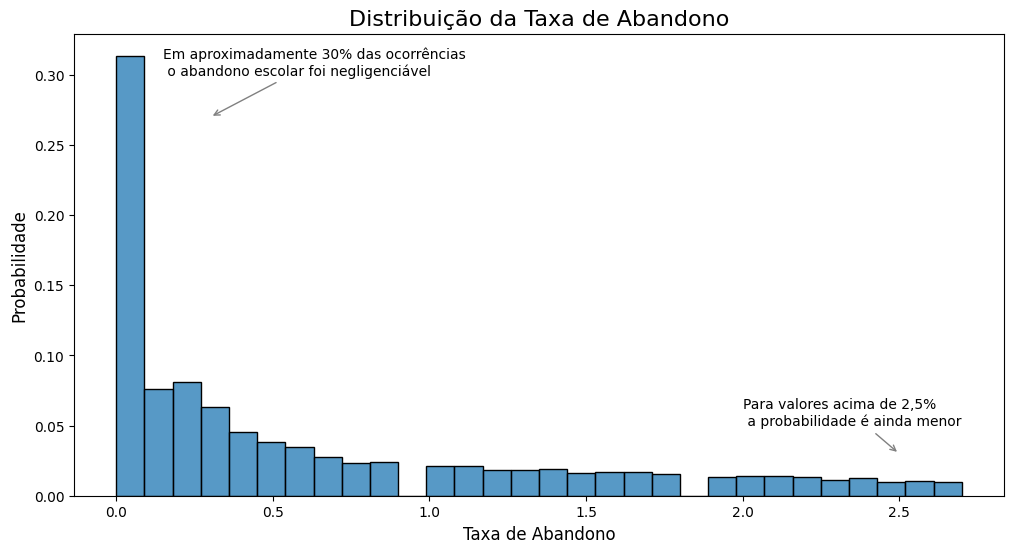

In [17]:
# Taxa de Abandono
plt.figure(figsize = (12,6))
sns.histplot(data = df, x=df.Taxa_Abandono[df.Taxa_Abandono < 2.71], bins = 30,
            stat = 'probability')
plt.title("Distribuição da Taxa de Abandono", fontsize=16)
plt.xlabel("Taxa de Abandono", fontsize=12)
plt.ylabel("Probabilidade", fontsize=12)
plt.annotate('Em aproximadamente 30% das ocorrências\n o abandono escolar foi negligenciável',
             xy=(0.3, 0.27),            # point to annotate
             xytext=(0.15, 0.3),       # location of the note
             arrowprops=dict(arrowstyle='->', color='gray'),
             fontsize=10, color='black')
plt.annotate('Para valores acima de 2,5%\n a probabilidade é ainda menor',
             xy=(2.5, 0.03),            # point to annotate
             xytext=(2, 0.05),       # location of the note
             arrowprops=dict(arrowstyle='->', color='gray'),
             fontsize=10, color='black')
sns.set_style("darkgrid")
plt.show;

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


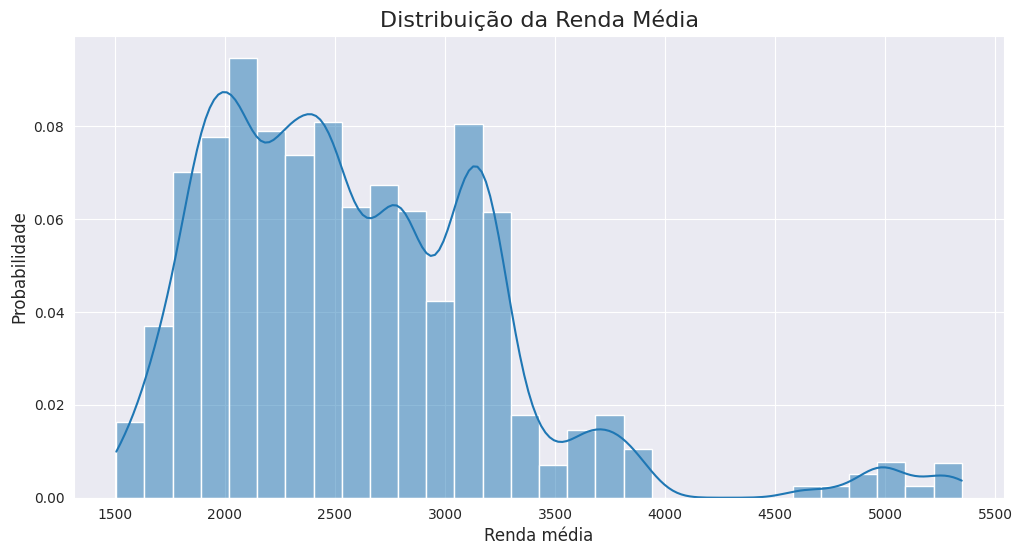

In [18]:
# Renda Média
plt.figure(figsize = (12,6))
sns.histplot(data = df, x=df.Renda_Media, bins = 30,
            kde = True,
            stat = 'probability')
plt.title("Distribuição da Renda Média", fontsize=16)
plt.xlabel("Renda média", fontsize=12)
plt.ylabel("Probabilidade", fontsize=12)
sns.set_style("darkgrid")
plt.show;

In [19]:
# Grupos de Abandono
# Preparo
#grupo_count = df['Grupo_de_Abandono'].value_counts()
#ordem_anos = ['3º Ano do Ensino Médio', '2º Ano do Ensino Médio', '1º Ano do Ensino Médio',
# '9º Ano do Ensino Fundamental', '8º Ano do Ensino Fundamental', '7º Ano do Ensino Fundamental',
# '6º Ano do Ensino Fundamental', '5º Ano do Ensino Fundamental', '4º Ano do Ensino Fundamental',
# '3º Ano do Ensino Fundamental', '2º Ano do Ensino Fundamental', '1º Ano do Ensino Fundamental']

# Gráfico
#plt.figure(figsize = (12,6))
#sns.barplot(x = grupo_count.values, y = grupo_count.index, order = ordem_anos)
#plt.title("Grupos de Abandono Mais Frequentes", fontsize=16)
#plt.xlabel("Frequência", fontsize=12)
#plt.ylabel("Grupo de Abandono", fontsize=12)
#plt.xlim(1700,1950)
#sns.set_style("darkgrid")
#plt.show;

# Aqui vale lembrar que o dataset não tem variável populacional

# Análise Multivariada

* *"Existe uma correlação entre a renda média mensal e a evasão escolar nas unidades federativas do Brasil?"*

In [20]:
df[['Taxa_Abandono', 'Renda_Media']].corr()

,Taxa_Abandono,Renda_Media
Taxa_Abandono,1.000000,-0.179538
Renda_Media,-0.179538,1.000000


Primeiramente, temos que a taxa de correlação entre a taxa de abandono é surpreendentemente baixa (-0,18). No entanto, vale explorar como ela muda ao longo dos valores.

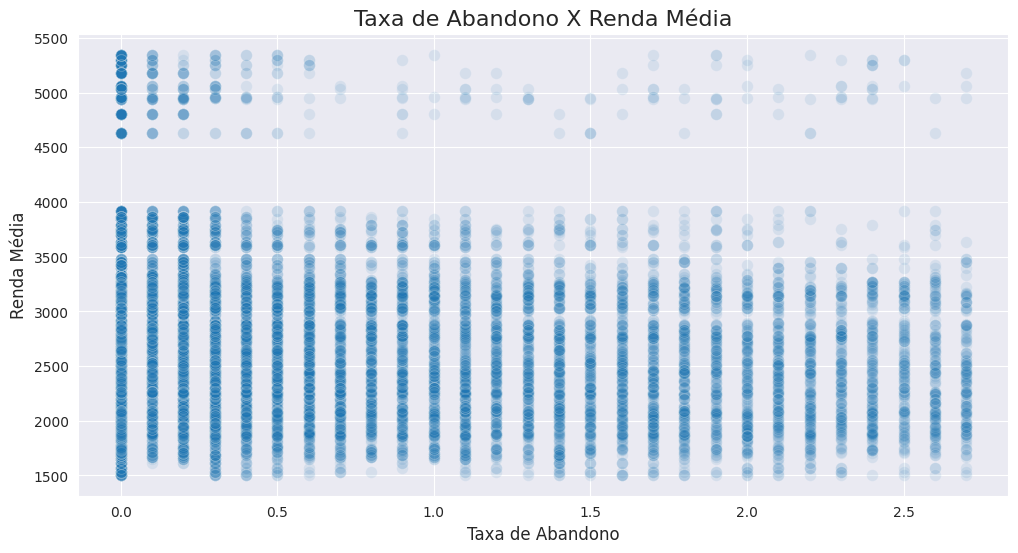

In [21]:
plt.figure(figsize = (12,6))
sns.scatterplot(x = df.Taxa_Abandono[df.Taxa_Abandono < 2.71], y='Renda_Media', data = df,
               s =70,
               alpha = 0.1)
plt.title("Taxa de Abandono X Renda Média", fontsize=16)
plt.xlabel("Taxa de Abandono", fontsize=12)
plt.ylabel("Renda Média", fontsize=12)
plt.show();

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Figure size 1200x600 with 0 Axes>

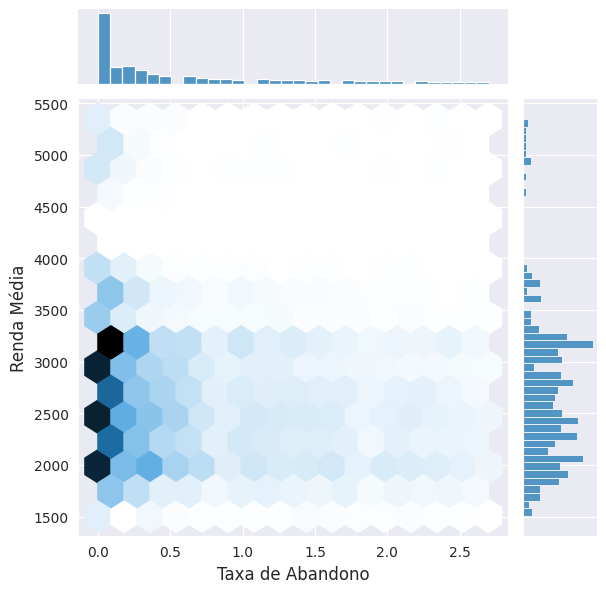

In [22]:
# Outra perspectiva 
plt.figure(figsize = (12,6))
sns.jointplot(x=df.Taxa_Abandono[df.Taxa_Abandono < 2.71], y='Renda_Media', data = df,
              gridsize = 15,
              kind="hex", 
              palette="Blues")
plt.xlabel("Taxa de Abandono", fontsize=12)
plt.ylabel("Renda Média", fontsize=12)
plt.show();

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


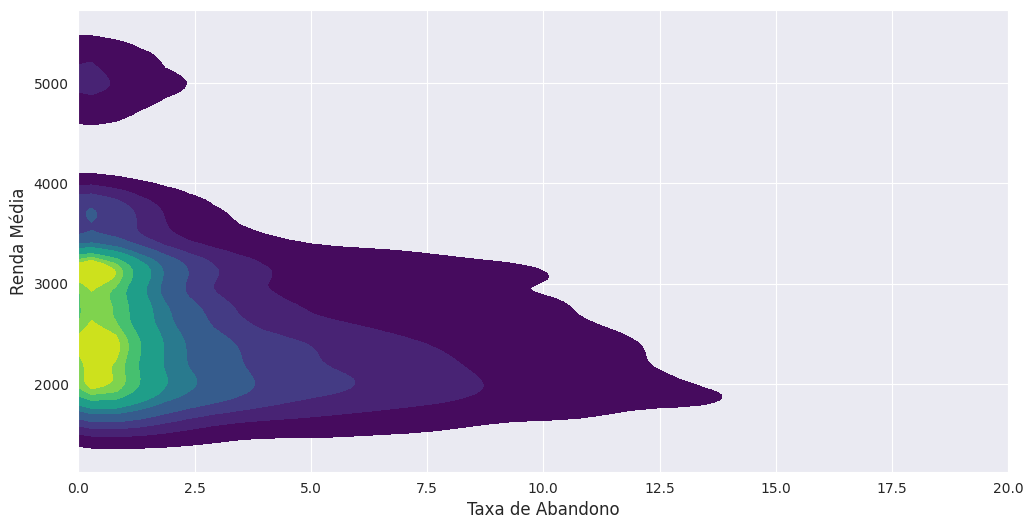

In [23]:
# Outra perspectiva 
plt.figure(figsize = (12,6))
sns.kdeplot(data=df, x='Taxa_Abandono', y='Renda_Media', fill=True, cmap='viridis', thresh=0.05)
plt.xlim(0,20)
plt.xlabel("Taxa de Abandono", fontsize=12)
plt.ylabel("Renda Média", fontsize=12)
plt.show();

Mas correlação é igual em diferentes pontos do eixo X (Taxa de Abandono)?

/tmp/ipykernel_13/2353194770.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  correlacoes = df.groupby('faixas_aban').apply(lambda g: g['Taxa_Abandono'].corr(g['Renda_Media'])).reset_index()
/tmp/ipykernel_13/2353194770.py:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  correlacoes = df.groupby('faixas_aban').apply(lambda g: g['Taxa_Abandono'].corr(g['Renda_Media'])).reset_index()
/usr/local/lib/python3.11/dist-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecate

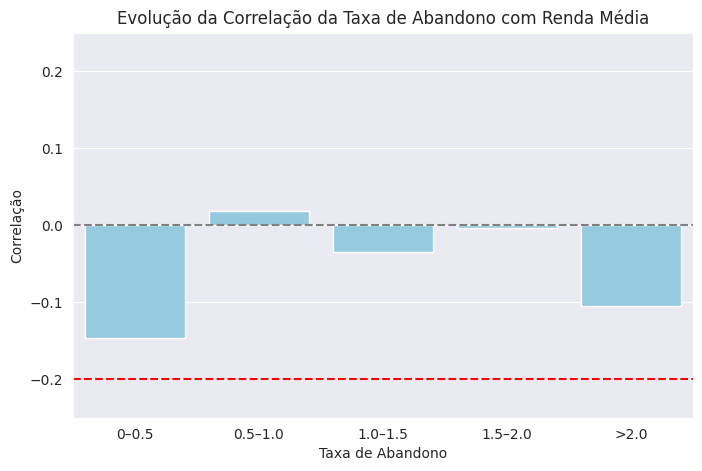

In [24]:

# Preparo
bins = [0, 0.5, 1.0, 1.5, 2.0, float('inf')]
faixas = ['0–0.5', '0.5–1.0', '1.0–1.5', '1.5–2.0', '>2.0']
df['faixas_aban'] = pd.cut(df['Taxa_Abandono'], bins=bins, labels=faixas)

correlacoes = df.groupby('faixas_aban').apply(lambda g: g['Taxa_Abandono'].corr(g['Renda_Media'])).reset_index()
correlacoes.columns = ['faixas_aban', 'correlacao']

# Gráfico
plt.figure(figsize=(8, 5))
sns.barplot(data=correlacoes, x='faixas_aban', y='correlacao', color='skyblue')
plt.title('Evolução da Correlação da Taxa de Abandono com Renda Média')
plt.ylabel('Correlação')
plt.xlabel('Taxa de Abandono')
plt.ylim(-0.25, 0.25)
plt.axhline(0, color='gray', linestyle='--')
plt.axhline(-0.2, color='red', linestyle='--', label='Correlação Fraca') 
plt.show();

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-l

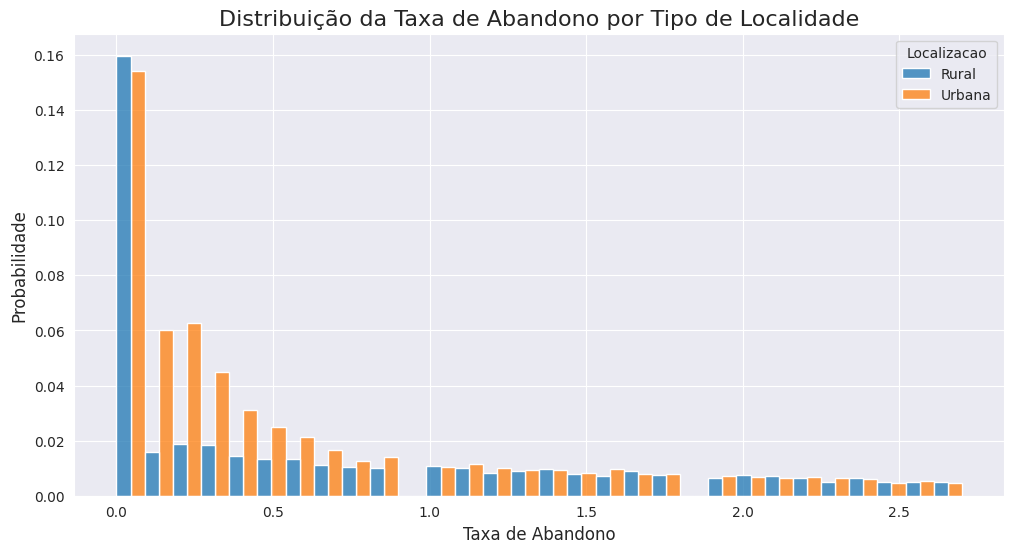

In [25]:
plt.figure(figsize = (12,6))
sns.histplot(data = df, x=df.Taxa_Abandono[df.Taxa_Abandono < 2.71], bins = 30,
            stat = 'probability',
            hue = df.Localizacao,
            multiple = 'dodge')
plt.title("Distribuição da Taxa de Abandono por Tipo de Localidade", fontsize=16)
plt.xlabel("Taxa de Abandono", fontsize=12)
plt.ylabel("Probabilidade", fontsize=12)
#plt.annotate('Em aproximadamente 30% das ocorrências\n o abandono escolar foi negligenciável',
#             xy=(0.3, 0.27),            # point to annotate
#             xytext=(0.15, 0.3),       # location of the note
#             arrowprops=dict(arrowstyle='->', color='gray'),
#             fontsize=10, color='black')
#plt.annotate('Para valores acima de 2,5%\n a probabilidade é ainda menor',
#             xy=(2.5, 0.03),            # point to annotate
#             xytext=(2, 0.05),       # location of the note
#             arrowprops=dict(arrowstyle='->', color='gray'),
#             fontsize=10, color='black')
sns.set_style("darkgrid")
plt.show;

"Como essa relação evoluiu entre os anos de 2012 a 2015?"

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


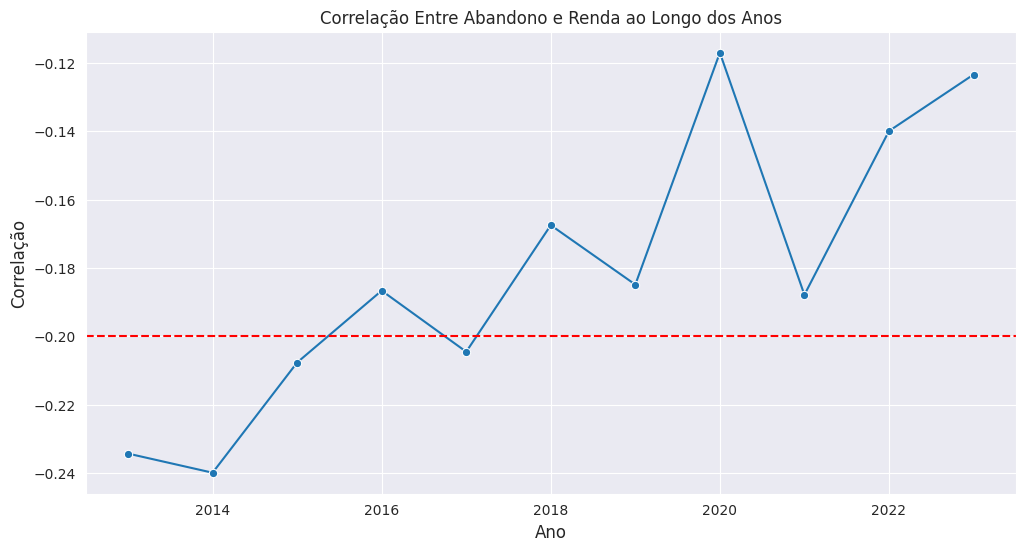

In [26]:
corr_por_ano = (
    df.groupby('Ano')[['Taxa_Abandono', 'Renda_Media']]
    .corr()
    .iloc[0::2, 1]  # Selecionando apenas a correlação desejada
    .reset_index())
#corr_por_ano

plt.figure(figsize = (12,6))
#sns.lineplot(data = df, x='Ano', y=df[['Taxa_Abandono', 'Renda_Media']].corr())
sns.lineplot(data=corr_por_ano, x='Ano', y='Renda_Media', marker='o')
plt.title("Correlação Entre Abandono e Renda ao Longo dos Anos")
plt.xlabel("Ano", fontsize = 12)
plt.ylabel("Correlação", fontsize = 12)
plt.axhline(-0.2, color='red', linestyle='--', label='Correlação Fraca') 
plt.show();

A correlação negativa aparentava ser mais forte na primeira metade do período investigado, mas enfraquece gradualmente até se tornar insignificante nos últimos anos.

"Como essa correlação se distribui entre os estados do Brasil?"

/tmp/ipykernel_13/500528569.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  correlacoes_est = df.groupby('Unidade_Geografica').apply(lambda g: g['Taxa_Abandono'].corr(g['Renda_Media'])).reset_index()


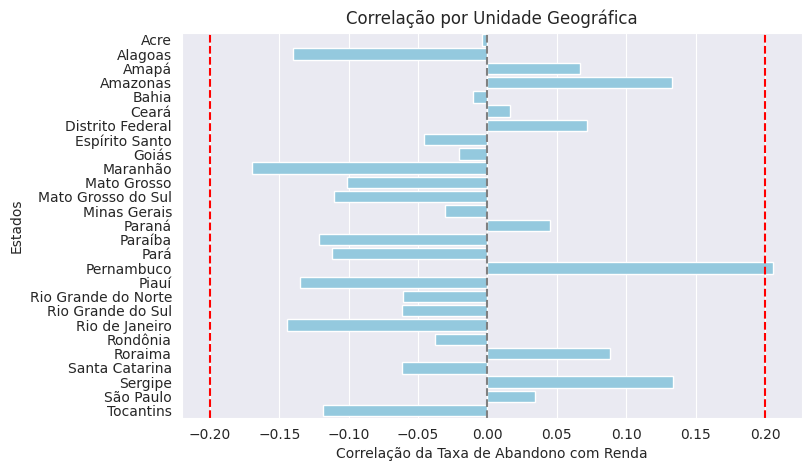

In [27]:
# Preparo
correlacoes_est = df.groupby('Unidade_Geografica').apply(lambda g: g['Taxa_Abandono'].corr(g['Renda_Media'])).reset_index()
correlacoes_est.columns = ['Unidade_Geografica', 'correlacao']

# Gráfico
plt.figure(figsize=(8, 5))
sns.barplot(data=correlacoes_est, x='correlacao', y='Unidade_Geografica', color='skyblue')
plt.title('Correlação por Unidade Geográfica')
plt.ylabel('Estados')
plt.xlabel('Correlação da Taxa de Abandono com Renda')
plt.axvline(0, color='gray', linestyle='--')
plt.axvline(0.2, color='red', linestyle='--', label='Correlação Fraca') 
plt.axvline(-0.2, color='red', linestyle='--', label='Correlação Fraca') 
plt.show();

A correlação é considerada no máximo fraca apenas em Pernambuco